# Business Problem

In this section, we are going to apply **cltv prediction** on a specific retail dataset and then **functionalize** the whole process.

The calculations and processes are shown below respectively:

* Importing required libraries:
    * numpy
    * pandas
    * datetime
    * matplotlib
    * sklearn
    * lifetimes (needs installation if not used before)
* Specific settings for pandas
* Importing and checking the dataset
* General information about the dataset
* Data Preprocessing:
    * Handling missing values
    * Removing the refunded items from the dataset
    * Correction of *Quantity* and *Price* columns
    * Calculation of *total price*
    * Creating a virtual current date
* Preparation of Lifetime Data Structure
    * Recency
    * T (Age of the customer)
    * Frequency
    * Monetary
* Setting BG-NBD Model
* Setting Gamma-Gamma Model
* Calculating cltv with BG-NBD Model and Gamma-Gamma Model
* Creation of Segments
* Exporting All Results to CSV File
* Functionalization of the Whole Process

# Dataset Story

**Context**

This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

**Content**

Attribute Information:

* **InvoiceNo:** Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
* **StockCode:** Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
* **Description:** Product (item) name. Nominal.
* **Quantity:** The quantities of each product (item) per transaction. Numeric.
* **InvoiceDate:** Invice date and time. Numeric. The day and time when a transaction was generated.
* **UnitPrice:** Unit price. Numeric. Product price per unit in sterling (Â£).
* **CustomerID:** Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
* **Country:** Country name. Nominal. The name of the country where a customer resides.

# Importing Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# adding lifetimes library
!pip install lifetimes
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

# specific settings for pandas
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: '%.4f' % x)

# Importing Dataset

In [ ]:
online_retail = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Datasets/online_retail_II.xlsx", sheet_name="Year 2010-2011")
df = online_retail.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom


# General Information About the Dataset

In [ ]:
def check_df(dataframe, head=5, tail=5):
    """
    Display various descriptive statistics and information about a DataFrame.

    This function prints the head, tail, shape, data types, size, number of null values,
    and quartile statistics (including every ten percent) of the provided DataFrame.

    Parameters
    ----------
    dataframe : DataFrame
        The DataFrame on which the descriptive methods are applied.

    head : int, optional
        The number of rows to display from the top of the DataFrame (default is 5).

    tail : int, optional
        The number of rows to display from the bottom of the DataFrame (default is 5).

    Returns
    -------
    None
        This function prints the output and does not return any value.
    """
    print('*'*20, 'HEAD', '*'*20)
    print(dataframe.head(head))
    print('*'*20, 'TAIL', '*'*20)
    print(dataframe.tail(tail))
    print('*'*20, 'SHAPE', '*'*20)
    print(dataframe.shape)
    print('*'*20, 'TYPES', '*'*20)
    print(dataframe.dtypes)
    print('*'*20, 'SIZE', '*'*20)
    print(dataframe.size)
    print('*'*20, 'NA', '*'*20)
    print(dataframe.isnull().sum())
    print('*'*20, 'QUARTILES', '*'*20)
    print(dataframe.describe([0, 0.01, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99, 1]).T)

In [ ]:
check_df(df)

******************** HEAD ********************
  Invoice StockCode                          Description  Quantity         InvoiceDate  Price  Customer ID         Country
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6 2010-12-01 08:26:00 2.5500   17850.0000  United Kingdom
1  536365     71053                  WHITE METAL LANTERN         6 2010-12-01 08:26:00 3.3900   17850.0000  United Kingdom
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8 2010-12-01 08:26:00 2.7500   17850.0000  United Kingdom
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6 2010-12-01 08:26:00 3.3900   17850.0000  United Kingdom
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6 2010-12-01 08:26:00 3.3900   17850.0000  United Kingdom
******************** TAIL ********************
       Invoice StockCode                      Description  Quantity         InvoiceDate   Price  Customer ID Country
541905  581587     22899     CHILDREN'S APRON DOLLY

# Data Preprocessing

In [ ]:
df.isnull().sum()

,0
Invoice,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
Price,0
Customer ID,135080
Country,0


In [ ]:
# Removing the missing values
df.dropna(inplace=True)

In [ ]:
# Removing the refunded items from the dataset
df = df[~df["Invoice"].str.contains("C", na=False)]

In [ ]:
# Selecting the quantity that are greater than 0
df = df[df["Quantity"] > 0]

In [ ]:
# Selecting the price that are greater than 0
df = df[df["Price"] > 0]

In [ ]:
# Calculation of total price
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [ ]:
df["InvoiceDate"].max()

Timestamp('2011-12-09 12:50:00')

In [ ]:
# Creating a virtual current date for the analyze
today_date = dt.datetime(2011, 12, 11)

In [ ]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,397885.0000,12.9882,1.0000,2.0000,6.0000,12.0000,80995.0000,179.3316
InvoiceDate,397885,2011-07-10 23:41:56.419316992,2010-12-01 08:26:00,2011-04-07 11:12:00,2011-07-31 14:39:00,2011-10-20 14:33:00,2011-12-09 12:50:00,NaN
Price,397885.0000,3.1165,0.0010,1.2500,1.9500,3.7500,8142.7500,22.0979
Customer ID,397885.0000,15294.4169,12346.0000,13969.0000,15159.0000,16795.0000,18287.0000,1713.1444


# Preparation of Lifetime Data Structure

1. **Recency:** Passing time from the last purchase as *weeks*
2. **T Age of the customer:** Calculacted based on the *weeks* and how long time has passed after the analysis since their last transaction
3. **Frequency:** Transcation frequency. Always must be greater than 1 because the customer should have at least two transactions.
4. **Monetary:** Mean profit per transaction.

!IMPORTANT NOTE!
Not total profit, profit per transaction

In [ ]:
cltv_df = df.groupby("Customer ID").agg({"InvoiceDate": [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                                              lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
                              "Invoice": lambda Invoice: Invoice.nunique(),
                              "TotalPrice": lambda TotalPrice: TotalPrice.sum()})

In [ ]:
cltv_df.head()

InvoiceDate             Invoice TotalPrice
             <lambda_0> <lambda_1> <lambda>   <lambda>
Customer ID                                           
12346.0000            0        326        1 77183.6000
12347.0000          365        368        7  4310.0000
12348.0000          282        359        4  1797.2400
12349.0000            0         19        1  1757.5500
12350.0000            0        311        1   334.4000

In [ ]:
cltv_df.columns = cltv_df.columns.droplevel(0)

In [ ]:
cltv_df.columns = ["recency", "T", "frequency", "monetary"]

In [ ]:
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0000,0,326,1,77183.6000
12347.0000,365,368,7,4310.0000
12348.0000,282,359,4,1797.2400
12349.0000,0,19,1,1757.5500
12350.0000,0,311,1,334.4000


In [ ]:
# Correcting monetary column because it was only showing the total profit
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

In [ ]:
# Correcting frequency column because it was also showing the 1 time transactions (freq must be greater than 1)
cltv_df = cltv_df[cltv_df["frequency"] > 1]

In [ ]:
# Correcting recency column by converting into weekly basis
cltv_df["recency"] = cltv_df["recency"] / 7

In [ ]:
# Correcting T column by converting into weekly basis
cltv_df["T"] = cltv_df["T"] / 7

In [ ]:
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12347.0000,52.1429,52.5714,7,615.7143
12348.0000,40.2857,51.2857,4,449.3100
12352.0000,37.1429,42.4286,8,313.2550
12356.0000,43.1429,46.5714,3,937.1433
12358.0000,21.2857,21.5714,2,584.0300


In [ ]:
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,2845.0000,28.4151,16.2667,0.0000,14.0000,29.5714,42.7143,53.2857
T,2845.0000,36.9692,14.7130,0.4286,27.4286,40.4286,51.2857,53.4286
frequency,2845.0000,5.9891,9.0442,2.0000,2.0000,4.0000,6.0000,209.0000
monetary,2845.0000,422.5083,1658.5913,3.4500,193.6553,303.7167,441.5750,84236.2500


# Setting the BG-NBD Model

In [ ]:
# penalizer_coef is that a penalty coefficient which finds the appropriate parameters
bgf = BetaGeoFitter(penalizer_coef=0.001)

In [ ]:
bgf.fit(cltv_df["frequency"], cltv_df["recency"], cltv_df["T"])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.12, alpha: 11.41, b: 2.49, r: 2.18>

# Top 10 customers that we expect the most purchase in 1 week

In [ ]:
bgf.conditional_expected_number_of_purchases_up_to_time(1, cltv_df["frequency"], cltv_df["recency"], cltv_df["T"]).sort_values(ascending=False).head(10)

,0
Customer ID,
12748.0000,3.2495
14911.0000,3.1264
17841.0000,1.9402
13089.0000,1.5374
14606.0000,1.4639
15311.0000,1.4336
12971.0000,1.3569
14646.0000,1.2064
13408.0000,0.9862


The same process, different method;

In [ ]:
bgf.predict(1, cltv_df["frequency"], cltv_df["recency"], cltv_df["T"]).sort_values(ascending=False).head(10)

,0
Customer ID,
12748.0000,3.2495
14911.0000,3.1264
17841.0000,1.9402
13089.0000,1.5374
14606.0000,1.4639
15311.0000,1.4336
12971.0000,1.3569
14646.0000,1.2064
13408.0000,0.9862


In [ ]:
cltv_df["expected_purc_1_week"] = bgf.predict(1, cltv_df["frequency"], cltv_df["recency"], cltv_df["T"])

In [ ]:
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_1_week
Customer ID,,,,,
12347.0000,52.1429,52.5714,7,615.7143,0.1413
12348.0000,40.2857,51.2857,4,449.3100,0.0920
12352.0000,37.1429,42.4286,8,313.2550,0.1824
12356.0000,43.1429,46.5714,3,937.1433,0.0862
12358.0000,21.2857,21.5714,2,584.0300,0.1223


In [ ]:
# Total expected transaction quantity in one week
cltv_df["expected_purc_1_week"].sum()

446.32655381737976

# Top 10 customers that we expect the most purchase in 1 month

In [ ]:
bgf.predict(4, cltv_df["frequency"], cltv_df["recency"], cltv_df["T"]).sort_values(ascending=False).head(10)

,0
Customer ID,
12748.0000,12.9633
14911.0000,12.4722
17841.0000,7.7398
13089.0000,6.1330
14606.0000,5.8399
15311.0000,5.7191
12971.0000,5.4131
14646.0000,4.8119
13408.0000,3.9341


In [ ]:
cltv_df["expected_purc_1_month"] = bgf.predict(4, cltv_df["frequency"], cltv_df["recency"], cltv_df["T"])

In [ ]:
cltv_df["expected_purc_1_month"].sum()

1776.8934732202908

# Top 10 customers that we expect the most purchase in 3 month

In [ ]:
bgf.predict(4*3, cltv_df["frequency"], cltv_df["recency"], cltv_df["T"]).sort_values(ascending=False).head(10)

,0
Customer ID,
12748.0000,38.6276
14911.0000,37.1641
17841.0000,23.0625
13089.0000,18.2736
14606.0000,17.4010
15311.0000,17.0411
12971.0000,16.1292
14646.0000,14.3340
13408.0000,11.7223


In [ ]:
cltv_df["expected_purc_3_month"] = bgf.predict(4*3, cltv_df["frequency"], cltv_df["recency"], cltv_df["T"])

In [ ]:
cltv_df["expected_purc_3_month"].sum()

5271.11243382635

# Total expected transaction amount by the company in one week

In [ ]:
bgf.predict(1, cltv_df["frequency"], cltv_df["recency"], cltv_df["T"]).sum()

446.32655381737976

# Total expected transaction amount by the company in one month

In [ ]:
bgf.predict(4, cltv_df["frequency"], cltv_df["recency"], cltv_df["T"]).sum()

1776.8934732202908

# Total expected transaction amount by the company in three months

In [ ]:
bgf.predict(4*3, cltv_df["frequency"], cltv_df["recency"], cltv_df["T"]).sum()

5271.11243382635

# Evaluation of the Prediction Results

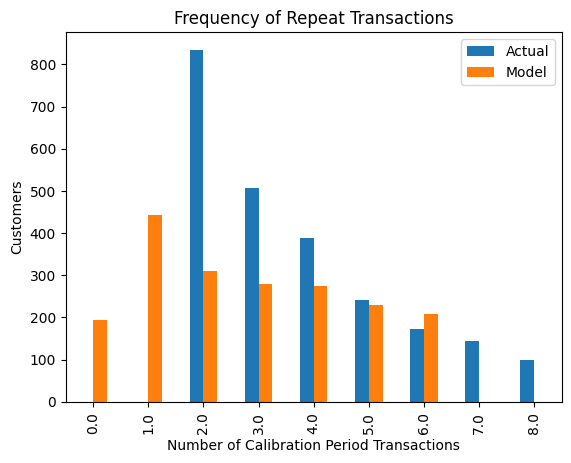

In [ ]:
plot_period_transactions(bgf)
plt.show()

# Setting the Gamma-Gamma Model

In [ ]:
ggf = GammaGammaFitter(penalizer_coef = 0.01)

In [ ]:
ggf.fit(cltv_df["frequency"], cltv_df["monetary"])

<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 3.79, q: 0.34, v: 3.72>

# Expected Average Profit

In [ ]:
# Top 5 customers' expected average profit between all the customers
ggf.conditional_expected_average_profit(cltv_df["frequency"], cltv_df["monetary"]).head()

,0
Customer ID,
12347.0000,632.0200
12348.0000,470.8035
12352.0000,320.7242
12356.0000,996.4109
12358.0000,641.9691


In [ ]:
# Expected average profit for all the customers
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df["frequency"], cltv_df["monetary"])

In [ ]:
cltv_df.sort_values("expected_average_profit", ascending=False).head()

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit
Customer ID,,,,,,,,
16446.0000,29.1429,29.4286,2,84236.2500,0.0988,0.3933,1.1666,92301.0619
15749.0000,13.8571,47.5714,3,14844.7667,0.0280,0.1116,0.3320,15764.0516
15098.0000,0.0000,26.1429,3,13305.5000,0.0101,0.0401,0.1188,14129.6000
12415.0000,44.7143,48.2857,21,5948.3110,0.3796,1.5139,4.5080,5998.3918
12590.0000,0.0000,30.2857,2,4932.1300,0.0115,0.0460,0.1363,5406.2527


# Calculating cltv with BG-NBD Model and Gamma-Gamma Model

In [ ]:
cltv = ggf.customer_lifetime_value(bgf,
                            cltv_df["frequency"],
                            cltv_df["recency"],
                            cltv_df["T"],
                            cltv_df["monetary"],
                            time=3,
                            freq="W",
                            discount_rate=0.01)

In [ ]:
cltv.head()

,clv
Customer ID,
12347.0000,1128.6400
12348.0000,547.0088
12352.0000,738.0371
12356.0000,1083.5382
12358.0000,982.0729


In [ ]:
cltv = cltv.reset_index()
cltv.head()

,Customer ID,clv
0,12347.0000,1128.6400
1,12348.0000,547.0088
2,12352.0000,738.0371
3,12356.0000,1083.5382
4,12358.0000,982.0729


In [ ]:
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit
Customer ID,,,,,,,,
12347.0000,52.1429,52.5714,7,615.7143,0.1413,0.5635,1.6784,632.0200
12348.0000,40.2857,51.2857,4,449.3100,0.0920,0.3668,1.0920,470.8035
12352.0000,37.1429,42.4286,8,313.2550,0.1824,0.7271,2.1631,320.7242
12356.0000,43.1429,46.5714,3,937.1433,0.0862,0.3435,1.0222,996.4109
12358.0000,21.2857,21.5714,2,584.0300,0.1223,0.4862,1.4388,641.9691


In [ ]:
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")

In [ ]:
cltv_final.head()

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv
0,12347.0000,52.1429,52.5714,7,615.7143,0.1413,0.5635,1.6784,632.0200,1128.6400
1,12348.0000,40.2857,51.2857,4,449.3100,0.0920,0.3668,1.0920,470.8035,547.0088
2,12352.0000,37.1429,42.4286,8,313.2550,0.1824,0.7271,2.1631,320.7242,738.0371
3,12356.0000,43.1429,46.5714,3,937.1433,0.0862,0.3435,1.0222,996.4109,1083.5382
4,12358.0000,21.2857,21.5714,2,584.0300,0.1223,0.4862,1.4388,641.9691,982.0729


In [ ]:
cltv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv
1970,16446.0000,29.1429,29.4286,2,84236.2500,0.0988,0.3933,1.1666,92301.0619,114516.9149
1122,14646.0000,50.4286,50.7143,73,3838.4386,1.2064,4.8119,14.3340,3847.6982,58682.8288
2761,18102.0000,52.2857,52.5714,60,4327.6217,0.9685,3.8636,11.5112,4340.3219,53160.9468
2458,17450.0000,51.2857,52.5714,46,4229.3650,0.7474,2.9815,8.8830,4245.5707,40127.8617
843,14096.0000,13.8571,14.5714,17,3833.2229,0.7287,2.8955,8.5526,3873.2473,35215.1583
36,12415.0000,44.7143,48.2857,21,5948.3110,0.3796,1.5139,4.5080,5998.3918,28770.0885
1257,14911.0000,53.1429,53.4286,201,715.5476,3.1264,12.4722,37.1641,716.1886,28321.0209
874,14156.0000,51.5714,53.1429,55,2134.1751,0.8775,3.5005,10.4298,2141.0438,23760.5466
1754,16000.0000,0.0000,0.4286,3,4131.2333,0.4220,1.6639,4.8439,4388.0165,22564.5503
2487,17511.0000,52.8571,53.4286,31,2937.4961,0.5088,2.0298,6.0476,2954.2658,19010.3290


# Creation of Segments

In [ ]:
cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

In [ ]:
cltv_final.head()

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv,segment
0,12347.0000,52.1429,52.5714,7,615.7143,0.1413,0.5635,1.6784,632.0200,1128.6400,A
1,12348.0000,40.2857,51.2857,4,449.3100,0.0920,0.3668,1.0920,470.8035,547.0088,B
2,12352.0000,37.1429,42.4286,8,313.2550,0.1824,0.7271,2.1631,320.7242,738.0371,B
3,12356.0000,43.1429,46.5714,3,937.1433,0.0862,0.3435,1.0222,996.4109,1083.5382,A
4,12358.0000,21.2857,21.5714,2,584.0300,0.1223,0.4862,1.4388,641.9691,982.0729,A


In [ ]:
cltv_final.groupby(["segment"]).agg({"count", "mean", "sum"})

Customer ID                          recency                        T                    frequency               monetary                      expected_purc_1_week                 expected_purc_1_month                 expected_purc_3_month                  expected_average_profit                        clv                       
              count           sum       mean   count        sum    mean count        sum    mean     count   sum    mean    count         sum     mean                count      sum   mean                 count      sum   mean                 count       sum   mean                   count         sum     mean count          sum      mean
segment                                                                                                                                                                                                                                                                                                                                           
D               712 11079720.0000 15561.4045     712 15761.1429 22.1364   712 28767.7143 40.4041       712  2181  3.0632      712 132140.0065 185.5899                  712  50.9350 0.0715                   712 202.8510 0.2849                   712  602.1604 0.8457                     712 143308.7036 201.2763   712  104286.7681  146.4702
C               711 10892305.0000 15319.6976     711 21876.4286 30.7685   711 27130.1429 38.1577       711  2923  4.1111      711 195886.5152 275.5085                  711  86.0485 0.1210                   711 342.6580 0.4819                   711 1016.9663 1.4303                     711 209131.5403 294.1372   711  274766.4382  386.4507
B               711 10889005.0000 15315.0563     711 20759.8571 29.1981   711 24621.2857 34.6291       711  3863  5.4332      711 270217.4314 380.0526                  711 115.4968 0.1624                   711 459.6450 0.6465                   711 1362.4628 1.9163                     711 285206.7020 401.1346   711  495811.4270  697.3438
A               711 10645181.0000 14972.1252     711 22443.4286 31.5660   711 24658.1429 34.6809       711  8072 11.3530      711 603792.1795 849.2154                  711 193.8463 0.2726                   711 771.7394 1.0854                   711 2289.5231 3.2201                     711 633105.4391 890.4437   711 1800018.6123 2531.6717

# Exporting All Results to CSV File

In [ ]:
cltv_final.to_csv("cltv_prediction.csv")

# Functionalization of the Whole Process

In [ ]:
def create_cltv_prediction(dataframe, month=3, csv=False, excel=False):
  # Data Preprocessing
  # Removing the missing values
  dataframe.dropna(inplace=True)
  # Removing the refunded items from the dataset
  dataframe = dataframe[~dataframe["Invoice"].str.contains("C", na=False)]
  # Selecting the quantity that are greater than 0
  dataframe = dataframe[dataframe["Quantity"] > 0]
  # Selecting the price that are greater than 0
  dataframe = dataframe[dataframe["Price"] > 0]
  # Calculation of total price
  dataframe["TotalPrice"] = dataframe["Quantity"] * dataframe["Price"]
  # Creating a virtual date for the analyze
  today_date = dt.datetime(2011, 12, 11)

  # Preparation of Lifetime Data Structure
  cltv_df = dataframe.groupby("Customer ID").agg({"InvoiceDate": [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                                              lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
                              "Invoice": lambda Invoice: Invoice.nunique(),
                              "TotalPrice": lambda TotalPrice: TotalPrice.sum()})
  cltv_df.columns = cltv_df.columns.droplevel(0)
  cltv_df.columns = ["recency", "T", "frequency", "monetary"]
  # Correcting monetary column because it was only showing the total profit
  cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]
  # Correcting frequency column because it was also showing the 1 time transactions (freq must be greater than 1)
  cltv_df = cltv_df[cltv_df["frequency"] > 1]
  # Correcting recency column by converting into weekly basis
  cltv_df["recency"] = cltv_df["recency"] / 7
  # Correcting T column by converting into weekly basis
  cltv_df["T"] = cltv_df["T"] / 7

  # Setting the BG-NBD Model
  bgf = BetaGeoFitter(penalizer_coef=0.001)
  bgf.fit(cltv_df["frequency"], cltv_df["recency"], cltv_df["T"])
  cltv_df["expected_purc_1_week"] = bgf.predict(1, cltv_df["frequency"], cltv_df["recency"], cltv_df["T"])
  cltv_df["expected_purc_1_month"] = bgf.predict(4, cltv_df["frequency"], cltv_df["recency"], cltv_df["T"])
  cltv_df["expected_purc_3_month"] = bgf.predict(4*3, cltv_df["frequency"], cltv_df["recency"], cltv_df["T"])

  # Setting the Gamma-Gamma Model
  ggf = GammaGammaFitter(penalizer_coef = 0.01)
  ggf.fit(cltv_df["frequency"], cltv_df["monetary"])
  # Expected average profit for all the customers
  cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df["frequency"], cltv_df["monetary"])

  # Calculating cltv with BG-NBD Model and Gamma-Gamma Model
  cltv = ggf.customer_lifetime_value(bgf,
                            cltv_df["frequency"],
                            cltv_df["recency"],
                            cltv_df["T"],
                            cltv_df["monetary"],
                            time=month,
                            freq="W",
                            discount_rate=0.01)
  cltv = cltv.reset_index()
  cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")

  # Creation of Segments
  cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

  # Exporting All Results to CSV and Excel Files
  if csv:
    cltv_final.to_csv("cltv_prediction.csv")
  if excel:
    cltv_final.to_excel("cltv_prediction.xlsx")

  return cltv_final

In [ ]:
df = online_retail.copy()

In [ ]:
create_cltv_prediction(df, csv=True, excel=True)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv,segment
0,12347.0000,52.1429,52.5714,7,615.7143,0.1413,0.5635,1.6784,632.0200,1128.6400,A
1,12348.0000,40.2857,51.2857,4,449.3100,0.0920,0.3668,1.0920,470.8035,547.0088,B
2,12352.0000,37.1429,42.4286,8,313.2550,0.1824,0.7271,2.1631,320.7242,738.0371,B
3,12356.0000,43.1429,46.5714,3,937.1433,0.0862,0.3435,1.0222,996.4109,1083.5382,A
4,12358.0000,21.2857,21.5714,2,584.0300,0.1223,0.4862,1.4388,641.9691,982.0729,A
5,12359.0000,39.1429,47.4286,4,1593.1450,0.0995,0.3966,1.1804,1666.8800,2093.3269,A
6,12360.0000,21.1429,28.7143,3,887.3533,0.1196,0.4762,1.4126,943.5420,1417.4606,A
7,12362.0000,41.7143,42.2857,10,522.6230,0.2240,0.8930,2.6566,532.2947,1504.3901,A
8,12363.0000,18.8571,34.7143,2,276.0000,0.0756,0.3011,0.8941,304.4556,289.5492,C
9,12364.0000,14.8571,16.1429,4,328.2750,0.2176,0.8646,2.5538,344.2405,934.5373,B
